In [1]:
# Change these values to add and num hidden layers, 
# Total layers=hidden+input+output
num_hidden_layers=10
num_neurons=500
#
#
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split
from matplotlib.pyplot import *
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import time
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
device

device(type='cuda')

In [5]:
#https://shashikachamod4u.medium.com/excel-csv-to-pytorch-dataset-def496b6bcc1
# import os
# import pandas as pd
from torch.utils.data import Dataset

class EQ_dataset(Dataset):
    def __init__(self,file_name_inp,file_name_out,file_name_test_in,file_name_test_out):
        X=pd.read_csv(file_name_inp,header=None)
        y=pd.read_csv(file_name_out,header=None)
        
        X_test=pd.read_csv(file_name_test_in,header=None)
        y_test=pd.read_csv(file_name_test_out,header=None)
        
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_test_scaled=scaler.transform(X_test)
        
        self.X_train= torch.tensor(X_scaled[:],dtype=torch.float32)
        self.y_train= torch.tensor(y[:].values,dtype=torch.float32)
        self.X_test= torch.tensor(X_test_scaled[:50],dtype=torch.float32) # use it for nep 3
        self.y_test= torch.tensor(y_test.values[:50],dtype=torch.float32)
#         self.X_test= torch.tensor(X_test_scaled,dtype=torch.float32) 
#         self.y_test= torch.tensor(y_test.values,dtype=torch.float32)
#         print(np.shape(self.X_train))
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
    
    
# EQ_set=EQ_dataset('IO_files/Input_real_eq_all_non_lin_large_accel_noPGA.csv','IO_files/Output_real_eq_all_non_lin_large_accel.csv','IO_files/ValidationX6_accel_noPGA.csv','IO_files/ValidationY6_accel.csv')
EQ_set=EQ_dataset('IO_files/Input_real_eq_all_non_lin_large_accel_noPGA.csv','IO_files/Output_real_eq_all_non_lin_large_accel.csv','IO_files/ValidationX_nep3_accel.csv','IO_files/ValidationY_nep3_accel.csv')
splitsize=0.1
train_set, val_set= random_split(EQ_set, [int(np.ceil((1-splitsize)*len(EQ_set))), int(np.floor(splitsize*len(EQ_set)))])
# splitsize=0.1
# train_set, val_set= random_split(train_val_set, [int((1-splitsize)*len(train_val_set)), int(splitsize*len(train_val_set))])
train_loader = torch.utils.data.DataLoader(train_set,batch_size=50, shuffle=True, num_workers=50)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=50, shuffle=True, num_workers=50)



torch.Size([1000000, 45])


In [5]:

num_out=len(EQ_set.y_test.T)
num_inputs=len(EQ_set.X_test.T)

class SimpleNet(nn.Module):
    def __init__(self,num_neurons,num_hidden_layers,num_inputs,num_out):
        super(SimpleNet, self).__init__() # takes the nn.module as super
        
        self.num_inputs=num_inputs
        self.num_out=num_out
        
        self.num_neurons=num_neurons
        self.num_hidden_layers=num_hidden_layers
        
        
        self.fc0 = nn.Linear(num_inputs, num_neurons) # first layer
        
        for ct in range(1,num_hidden_layers+1):
            exec("self.fc%d = nn.Linear(num_neurons, num_neurons)"%ct)
        exec("self.fc%d = nn.Linear(num_neurons, num_out)"%(ct+1))

    def forward(self, x):
        x = x
        for ct in np.arange(0,self.num_hidden_layers+1):
            x=eval('F.relu(self.fc%d(x))'%ct)
#             print('F.relu(self.fc%d(x))'%ct)
#             print(ct)
#             print(x.shape)
#             print(x)
        x = eval('self.fc%d(x)'%(ct+1))
#         print('self.fc%d(x)'%(ct+1))
#         print(ct+1)
#         print(x.shape)
#         print(x)
        return x


simplenet = SimpleNet(num_neurons,num_hidden_layers,num_inputs,num_out)
print(simplenet)
simplenet.to(device)




SimpleNet(
  (fc0): Linear(in_features=45, out_features=500, bias=True)
  (fc1): Linear(in_features=500, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=500, bias=True)
  (fc5): Linear(in_features=500, out_features=500, bias=True)
  (fc6): Linear(in_features=500, out_features=500, bias=True)
  (fc7): Linear(in_features=500, out_features=500, bias=True)
  (fc8): Linear(in_features=500, out_features=500, bias=True)
  (fc9): Linear(in_features=500, out_features=500, bias=True)
  (fc10): Linear(in_features=500, out_features=500, bias=True)
  (fc11): Linear(in_features=500, out_features=2, bias=True)
)


SimpleNet(
  (fc0): Linear(in_features=45, out_features=500, bias=True)
  (fc1): Linear(in_features=500, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=500, bias=True)
  (fc5): Linear(in_features=500, out_features=500, bias=True)
  (fc6): Linear(in_features=500, out_features=500, bias=True)
  (fc7): Linear(in_features=500, out_features=500, bias=True)
  (fc8): Linear(in_features=500, out_features=500, bias=True)
  (fc9): Linear(in_features=500, out_features=500, bias=True)
  (fc10): Linear(in_features=500, out_features=500, bias=True)
  (fc11): Linear(in_features=500, out_features=2, bias=True)
)

In [6]:
N_epochs=200
tol=0.2
loss_function = nn.MSELoss()

def loss_function_custom(output, labels):
    y=labels
    y_predict=output
    return loss_function(y[:,1]/torch.mean(y[:,1]),y_predict[:,1]/torch.mean(y[:,1]))+loss_function(y[:,0]/torch.mean(y[:,0]),y_predict[:,0]/torch.mean(y[:,0]))
    




#optimizer = torch.optim.SGD(simplenet.parameters(), lr=1e-4, momentum=0.9)
#optimizer = torch.optim.Adam(simplenet.parameters(), lr=1e-4, )
optimizer = torch.optim.Adam(simplenet.parameters(), lr=1e-4, )

elapsed_time_fl=0

check =0

for epoch in range(N_epochs):
    print('####################################################################################################')
    start = time.time()
    train_loss = 0.0
    val_loss=0.0
    simplenet.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = simplenet(inputs)
        loss = loss_function(outputs, labels)  
#         loss = loss_function_custom(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


    
    simplenet.eval() 
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = simplenet(inputs)
#         loss = loss_function(outputs, labels)
        loss = loss_function_custom(outputs, labels)
        val_loss += loss.item()
    print("Epoch: {} Train Loss: {} Val Loss: {}".format(epoch,train_loss/len(train_loader),val_loss/len(val_loader)))
    if epoch==0:
        train_loss_prev=train_loss/len(train_loader)
        val_loss_prev=val_loss/len(val_loader)
        
    del_train_loss=train_loss_prev-train_loss/len(train_loader)
    del_val_loss=val_loss_prev-val_loss/len(val_loader)
    
    train_loss_prev=train_loss/len(train_loader)
    val_loss_prev=val_loss/len(val_loader)
    print('check=',check)
    print('Change in train loss=',del_train_loss)
    print('Change in val loss=',del_val_loss)
    elapsed_time_fl = elapsed_time_fl+(time.time() - start) 
    print("Elapsed Time:",elapsed_time_fl)
    print('####################################################################################################')
    if del_val_loss<tol*np.abs(del_train_loss):
        check+=1
    if check>2 and del_val_loss>tol*np.abs(del_train_loss):
        check=0
    if check>3:
        print('Overfitting')
        break
    
    

####################################################################################################
Epoch: 0 Train Loss: 0.06372442046045843 Val Loss: 0.03976929343305528
check= 0
Change in train loss= 0.0
Change in val loss= 0.0
Elapsed Time: 81.4979248046875
####################################################################################################
####################################################################################################
Epoch: 1 Train Loss: 0.03486284350800432 Val Loss: 0.0306456804741174
check= 0
Change in train loss= 0.02886157695245411
Change in val loss= 0.009123612958937884
Elapsed Time: 164.2390718460083
####################################################################################################
####################################################################################################
Epoch: 2 Train Loss: 0.02741547721448458 Val Loss: 0.02540102632716298
check= 0
Change in train loss= 0.007447366293519737
Change in val los

Epoch: 21 Train Loss: 0.008087390461018206 Val Loss: 0.01434795234282501
check= 2
Change in train loss= 0.000269404936413694
Change in val loss= 9.407783858478118e-05
Elapsed Time: 1833.1706128120422
####################################################################################################
####################################################################################################
Epoch: 22 Train Loss: 0.007854844723569437 Val Loss: 0.01436426086188294
check= 2
Change in train loss= 0.00023254573744876939
Change in val loss= -1.6308519057929918e-05
Elapsed Time: 1915.120061635971
####################################################################################################
####################################################################################################
Epoch: 23 Train Loss: 0.007600034775626328 Val Loss: 0.014481728909304365
check= 3
Change in train loss= 0.0002548099479431085
Change in val loss= -0.0001174680474214252
Elapsed Time: 1999.1315

-5.924299240112305
-3.5111846923828125
-6.154487435277026
-3.5112247329101045
1.5153808e-05
0.0052008997


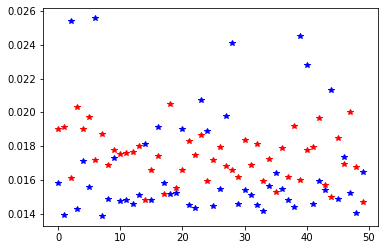

In [243]:
simplenet_on_cpu=simplenet.to('cpu')
from sklearn.metrics import mean_squared_error
X=EQ_set.X_test
y=EQ_set.y_test
y_predict=simplenet_on_cpu(X).detach().numpy()
y_actual=y.detach().numpy()
plot(y_predict[:,0],'b*')
plot(y_actual[:,0],'r*')


print(explained_variance_score(y_actual[:,0], y_predict[:,0], sample_weight=None, multioutput='uniform_average'))
print(explained_variance_score(y_actual[:,1], y_predict[:,1], sample_weight=None, multioutput='uniform_average'))
print(r2_score(y_actual[:,0], y_predict[:,0]))
print(r2_score(y_actual[:,1], y_predict[:,1]))

print(mean_squared_error(y_actual[:,0], y_predict[:,0]))
print(mean_squared_error(y_actual[:,1], y_predict[:,1]))

# figure(2)
# hist(y_actual[:,0],density=True)
# hist(y_predict[:,0],alpha=0.5,density=True)



### Testing data

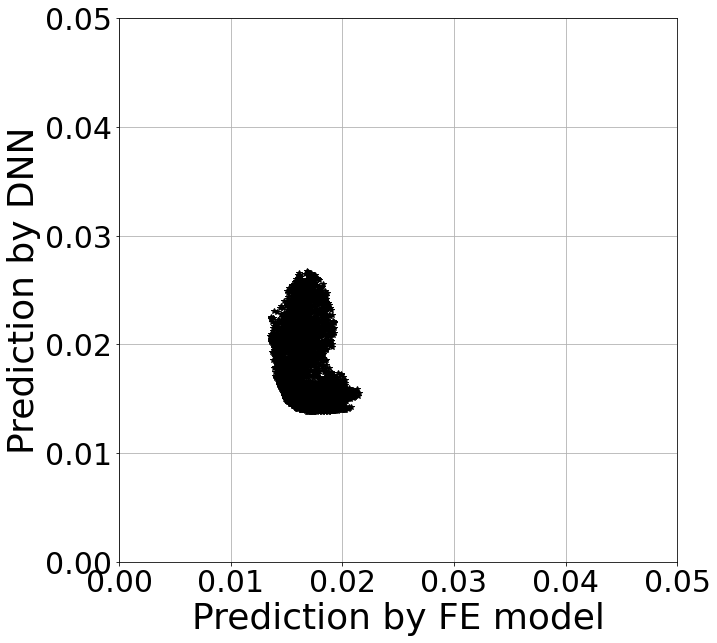

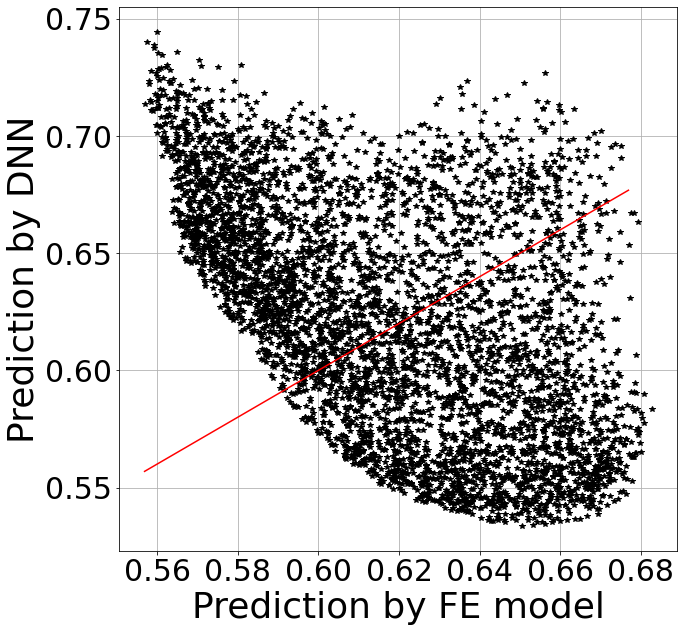

In [82]:
fntsz=36
fig = figure(100,figsize=(10,10))
plot(y_actual[:,0], y_predict[:,0],'k*')
plot(np.arange(np.min(y_actual[:,0]),np.max(y_actual[:,0]),0.01), np.arange(np.min(y_actual[:,0]),np.max(y_actual[:,0]),0.01),'r')
xlabel('Prediction by FE model',fontsize=fntsz)
ylabel('Prediction by DNN',fontsize=fntsz)
grid(True)
yticks(fontsize=fntsz/1.2)
xticks(fontsize=fntsz/1.2)
xlim([0,0.05])
ylim([0,0.05])
savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/DNN_performance_disp.pdf'),bbox_inches='tight')

fig = figure(101,figsize=(10,10))
plot(y_actual[:,1], y_predict[:,1],'k*')
plot(np.arange(np.min(y_actual[:,1]),np.max(y_actual[:,1]),0.01), np.arange(np.min(y_actual[:,1]),np.max(y_actual[:,1]),0.01),'r')
xlabel('Prediction by FE model',fontsize=fntsz)
ylabel('Prediction by DNN',fontsize=fntsz)

grid(True)
yticks(fontsize=fntsz/1.2)
xticks(fontsize=fntsz/1.2)
savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/DNN_performance_acc.pdf'),bbox_inches='tight')

### Validation data

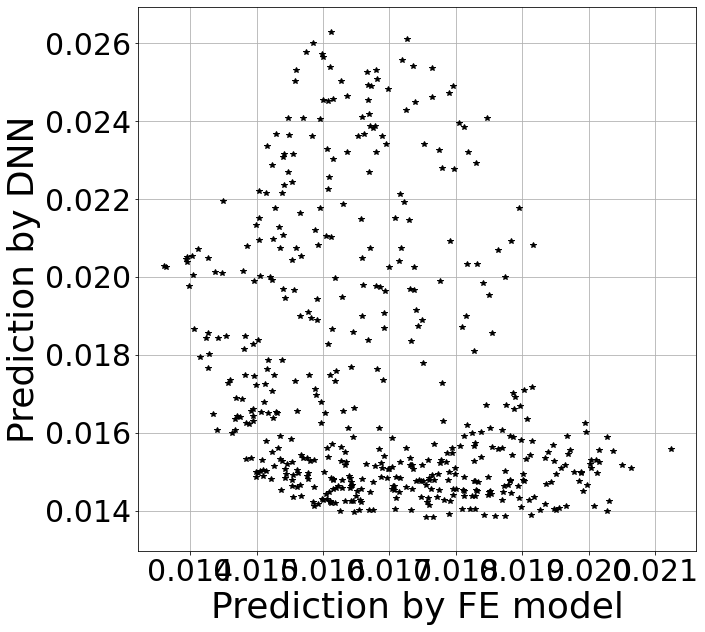

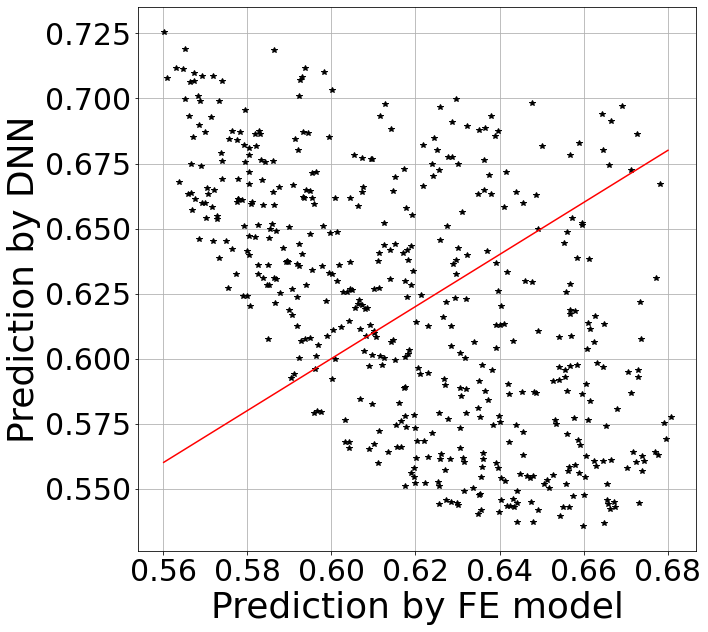

In [44]:
fntsz=36
fig = figure(100,figsize=(10,10))
plot(y_actual[:,0], y_predict[:,0],'k*')
plot(np.arange(np.min(y_actual[:,0]),np.max(y_actual[:,0]),0.01), np.arange(np.min(y_actual[:,0]),np.max(y_actual[:,0]),0.01),'r')
xlabel('Prediction by FE model',fontsize=fntsz)
ylabel('Prediction by DNN',fontsize=fntsz)
grid(True)
yticks(fontsize=fntsz/1.2)
xticks(fontsize=fntsz/1.2)
savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/DNN_performance_disp_LP.pdf'),bbox_inches='tight')

fig = figure(101,figsize=(10,10))
plot(y_actual[:,1], y_predict[:,1],'k*')
plot(np.arange(np.min(y_actual[:,1]),np.max(y_actual[:,1]),0.01), np.arange(np.min(y_actual[:,1]),np.max(y_actual[:,1]),0.01),'r')
xlabel('Prediction by FE model',fontsize=fntsz)
ylabel('Prediction by DNN',fontsize=fntsz)

grid(True)
yticks(fontsize=fntsz/1.2)
xticks(fontsize=fntsz/1.2)
savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/DNN_performance_LP.pdf'),bbox_inches='tight')


[0.7796141743659973, 0.6, 0.16]
[4.058103442192078, 0.8, 0.26]
[9.223162174224854, 1, 0.36]
[11.295517683029175, 0.8, 0.46]
[19.53213329315185, 0.6, 0.56]
[0.1927273452281952, 0.6, 0.16]
[0.8099621683359146, 0.8, 0.26]
[2.624149799346924, 1, 0.36]
[4.587106227874756, 0.8, 0.46]
[6.6983190774917585, 0.6, 0.56]


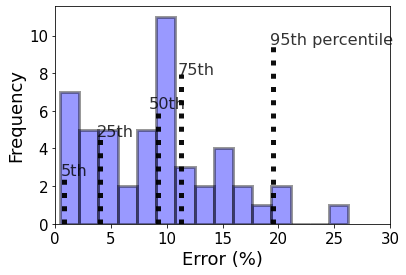

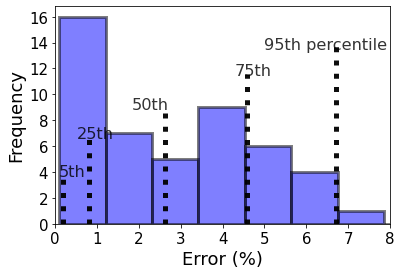

In [240]:
## generate histogram for generated eq
fntsz=18
err_disp=100*np.abs(y_predict[:,0]-y_actual[:,0])/y_actual[:,0]
err_disp=err_disp[np.where(err_disp<40)]
fig, ax = subplots(figsize = (6,4))

# fig,ax=subplot()
disp_hist=hist(err_disp,bins=15, alpha = 0.4, lw=3, color= 'b',histtype='bar',ec='black')
disp_hist_vals=disp_hist[0]

# avocado=pd.DataFrame(err_disp)
# avocado.plot(kind = "hist", density = True, alpha = 0.65, bins = 15) 
quants = [[np.quantile(err_disp, 0.05), 0.6, 0.16], [np.quantile(err_disp, 0.25), 0.8, 0.26], [np.quantile(err_disp, 0.50), 1, 0.36],  [np.quantile(err_disp, 0.75), 0.8, 0.46], [np.quantile(err_disp, 0.95), 0.6, 0.56]]

# Plot the lines with a loop
txt=np.array(['5th','25th','50th','75th','95th percentile'])
ct=0
for i in quants:
    print(i)
    ax.axvline(i[0], alpha = 0.95, ymax = 1.5*i[2], linestyle = ":",color= 'k',lw=5)
    if ct==0:
        ax.text(i[0]-.3, 16*i[2]+0.5*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==1:
        ax.text(i[0]-.3, 16*i[2]+0.5*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==2:
        ax.text(i[0]-.8, 16*i[2]+0.2*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==3:
        ax.text(i[0]-.3, 16*i[2]+0.2*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    else:
        ax.text(i[0]-.3, 16*i[2]+0.15*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
#     ax.text(i[0]+.3, disp_hist_vals[ct], txt[ct], size = 10, alpha = 0.8)
    ct=ct+1
xlim([0,30])
ylabel('Frequency',fontsize=fntsz)
xlabel('Error (%)',fontsize=fntsz)
# grid(True)
yticks(fontsize=fntsz/1.2)
xticks(fontsize=fntsz/1.2)
# savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/hist_disp_sdof.pdf'),bbox_inches='tight')
savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/hist_disp_sdof_gen.pdf'),bbox_inches='tight')
# ax.text(np.quantile(err_disp, 0.25)-.13, 0.27, "25th", size = 11, alpha = 0.85)
# ax.text(np.quantile(err_disp, 0.5)-.13, 0.37, "50th", size = 12, alpha = 1)
# ax.text(np.quantile(err_disp, 0.75)-.13, 0.47, "75th", size = 11, alpha = 0.85)
# ax.text(np.quantile(err_disp, 0.95)-.25, 0.57, "95th Percentile", size = 10, alpha =.8)


err_acc=100*np.abs(y_predict[:,1]-y_actual[:,1])/y_actual[:,1]
err_acc=err_acc[np.where(err_acc<40)]
fig, ax = subplots(figsize = (6,4))

# fig,ax=subplot()
disp_hist=hist(err_acc,bins=15, alpha = 0.5, lw=3, color= 'b',histtype='bar',ec='black')
disp_hist_vals=disp_hist[0]

# avocado=pd.DataFrame(err_disp)
# avocado.plot(kind = "hist", density = True, alpha = 0.65, bins = 15) 
quants = [[np.quantile(err_acc, 0.05), 0.6, 0.16], [np.quantile(err_acc, 0.25), 0.8, 0.26], [np.quantile(err_acc, 0.50), 1, 0.36],  [np.quantile(err_acc, 0.75), 0.8, 0.46], [np.quantile(err_acc, 0.95), 0.6, 0.56]]

# Plot the lines with a loop
txt=np.array(['5th','25th','50th','75th','95th percentile'])
ct=0
for i in quants:
    print(i)
    ax.axvline(i[0], alpha = 0.95, ymax = 1.5*i[2], linestyle = ":",color= 'k',lw=5)
    if ct==0:
        ax.text(i[0]-.1, 23*i[2]+0.6*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==1:
        ax.text(i[0]-.3, 23*i[2]+0.6*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==2:
        ax.text(i[0]-.8, 23*i[2]+0.3*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==3:
        ax.text(i[0]-.3, 23*i[2]+0.3*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    else:
        ax.text(i[0]-1.7, 23*i[2]+0.15*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
#     ax.text(i[0]+.3, disp_hist_vals[ct], txt[ct], size = 10, alpha = 0.8)
    ct=ct+1

ylabel('Frequency',fontsize=fntsz)
xlabel('Error (%)',fontsize=fntsz)
# grid(True)
yticks(fontsize=fntsz/1.2)
xticks(fontsize=fntsz/1.2)

# xlim([0,40])
# savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/hist_acc_sdof.pdf'),bbox_inches='tight')

xlim([0,8])
savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/hist_acc_sdof_gen.pdf'),bbox_inches='tight')







[2.713413381576538, 0.6, 0.16]
[10.542394638061523, 0.8, 0.26]
[15.998555183410645, 1, 0.36]
[19.63093376159668, 0.8, 0.46]
[27.12912864685058, 0.6, 0.56]
[0.7617995694279671, 0.6, 0.16]
[5.990654468536377, 0.8, 0.26]
[10.641888618469238, 1, 0.36]
[12.6668062210083, 0.8, 0.46]
[19.05321369171142, 0.6, 0.56]


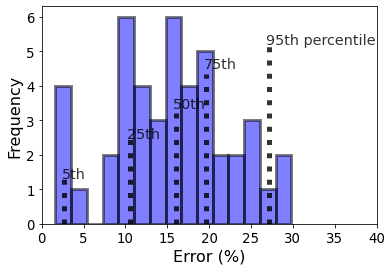

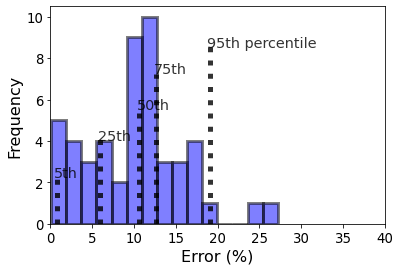

In [248]:
# Generate histo for loma prieta
fntsz=16
err_disp=100*np.abs(y_predict[:,0]-y_actual[:,0])/y_actual[:,0]
err_disp=err_disp[np.where(err_disp<40)]
fig, ax = subplots(figsize = (6,4))

# fig,ax=subplot()
disp_hist=hist(err_disp,bins=15, alpha = 0.5, lw=3, color= 'b',histtype='bar',ec='black')
disp_hist_vals=disp_hist[0]

# avocado=pd.DataFrame(err_disp)
# avocado.plot(kind = "hist", density = True, alpha = 0.65, bins = 15) 
quants = [[np.quantile(err_disp, 0.05), 0.6, 0.16], [np.quantile(err_disp, 0.25), 0.8, 0.26], [np.quantile(err_disp, 0.50), 1, 0.36],  [np.quantile(err_disp, 0.75), 0.8, 0.46], [np.quantile(err_disp, 0.95), 0.6, 0.56]]

# Plot the lines with a loop
txt=np.array(['5th','25th','50th','75th','95th percentile'])
ct=0
for i in quants:
    print(i)
    ax.axvline(i[0], alpha = 0.8, ymax = 1.5*i[2], linestyle = ":",color= 'k',lw=5)
    if ct==0:
        ax.text(i[0]-.3, 8.2*i[2]+0.25*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==1:
        ax.text(i[0]-.3, 8.2*i[2]+0.35*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==2:
        ax.text(i[0]-.3, 8.2*i[2]+0.2*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==3:
        ax.text(i[0]-.3, 8.2*i[2]+0.25*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    else:
        ax.text(i[0]-.3, 8.2*i[2]+0.15*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
#     ax.text(i[0]+.3, disp_hist_vals[ct], txt[ct], size = 10, alpha = 0.8)
    ct=ct+1
xlim([0,40])
ylabel('Frequency',fontsize=fntsz)
xlabel('Error (%)',fontsize=fntsz)
# grid(True)
yticks(fontsize=fntsz/1.2)
xticks(fontsize=fntsz/1.2)
savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/hist_disp_sdof.pdf'),bbox_inches='tight')

# ax.text(np.quantile(err_disp, 0.25)-.13, 0.27, "25th", size = 11, alpha = 0.85)
# ax.text(np.quantile(err_disp, 0.5)-.13, 0.37, "50th", size = 12, alpha = 1)
# ax.text(np.quantile(err_disp, 0.75)-.13, 0.47, "75th", size = 11, alpha = 0.85)
# ax.text(np.quantile(err_disp, 0.95)-.25, 0.57, "95th Percentile", size = 10, alpha =.8)


err_acc=100*np.abs(y_predict[:,1]-y_actual[:,1])/y_actual[:,1]
err_acc=err_acc[np.where(err_acc<40)]
fig, ax = subplots(figsize = (6,4))

# fig,ax=subplot()
disp_hist=hist(err_acc,bins=15, alpha = 0.5, lw=3, color= 'b',histtype='bar',ec='black')
disp_hist_vals=disp_hist[0]

# avocado=pd.DataFrame(err_disp)
# avocado.plot(kind = "hist", density = True, alpha = 0.65, bins = 15) 
quants = [[np.quantile(err_acc, 0.05), 0.6, 0.16], [np.quantile(err_acc, 0.25), 0.8, 0.26], [np.quantile(err_acc, 0.50), 1, 0.36],  [np.quantile(err_acc, 0.75), 0.8, 0.46], [np.quantile(err_acc, 0.95), 0.6, 0.56]]

# Plot the lines with a loop
txt=np.array(['5th','25th','50th','75th','95th percentile'])
ct=0
for i in quants:
    print(i)
    ax.axvline(i[0], alpha = 0.8, ymax = 1.5*i[2], linestyle = ":",color= 'k',lw=5)
    if ct==0:
        ax.text(i[0]-.3, 14.2*i[2]+0.25*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==1:
        ax.text(i[0]-.3, 14.2*i[2]+0.35*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==2:
        ax.text(i[0]-.3, 14.2*i[2]+0.2*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    elif ct==3:
        ax.text(i[0]-.3, 14.2*i[2]+0.25*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
    else:
        ax.text(i[0]-.3, 14.2*i[2]+0.15*ct, txt[ct], size = 10, alpha = 0.8,fontsize=0.9*fntsz)
#     ax.text(i[0]+.3, disp_hist_vals[ct], txt[ct], size = 10, alpha = 0.8)
    ct=ct+1

ylabel('Frequency',fontsize=fntsz)
xlabel('Error (%)',fontsize=fntsz)
# grid(True)
yticks(fontsize=fntsz/1.2)
xticks(fontsize=fntsz/1.2)

xlim([0,40])
savefig(os.path.expanduser('~/Dropbox/Research/Writing/Building_ML_paper_2021/figures/hist_acc_sdof.pdf'),bbox_inches='tight')









In [179]:
s=np.where(err_disp<40)
s

(array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49]),)

0.9436675310134888
0.9417958364832845
2.713939e-06
0.0009904341


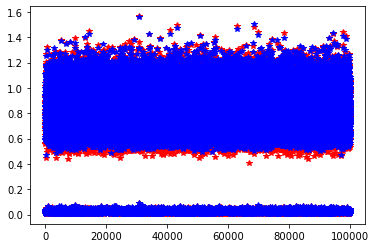

In [128]:
from sklearn.metrics import mean_squared_error
X, y=val_set[:]
y_predict=simplenet_on_cpu(X).detach().numpy()
y_actual=y.detach().numpy()
plot(y_actual,'r*')
plot(y_predict,'b*')


print(explained_variance_score(y_actual[:,1], y_predict[:,1], sample_weight=None, multioutput='uniform_average'))
print(r2_score(y_actual, y_predict))
print(mean_squared_error(y_actual[:,0], y_predict[:,0]))
print(mean_squared_error(y_actual[:,1], y_predict[:,1]))

7.141591979706973

0.9425226449966431
0.9422994358952927
0.0004965361


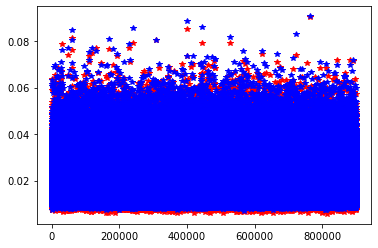

In [158]:
from sklearn.metrics import mean_squared_error
X, y=train_set[:]
y_predict=simplenet_on_cpu(X).detach().numpy()
y_actual=y.detach().numpy()
plot(y_actual[:,0],'r*')
plot(y_predict[:,0],'b*')






print(explained_variance_score(y_actual, y_predict, sample_weight=None, multioutput='uniform_average'))
print(r2_score(y_actual, y_predict))
print(mean_squared_error(y_actual, y_predict))

In [97]:
torch.save(simplenet_on_cpu, 'simple_net_accel.pt')

-1.6983412504196167
-185.456930439455
0.07733036


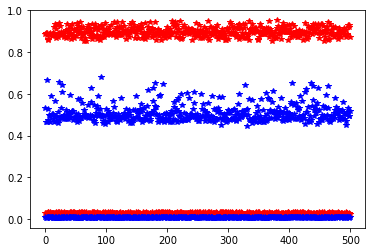

In [156]:
model=torch.load('simple_net_accel.pt')
model.eval()
X=EQ_set.X_test
y=EQ_set.y_test
y_predict=model(X).detach().numpy()
y_actual=y.detach().numpy()
plot(y_actual,'r*')
plot(y_predict,'b*')
print(explained_variance_score(y_actual, y_predict, sample_weight=None, multioutput='uniform_average'))
print(r2_score(y_actual, y_predict))
print(mean_squared_error(y_actual, y_predict))

In [ ]:
# np.savetxt('validationX.txt',X.numpy())
# np.savetxt('validationy.txt',y.numpy())
# X=pd.read_csv('IO_files/Input_real_eq26.csv',header=None)
# y=pd.read_csv('IO_files/Output_real_eq26.csv',header=None)

In [ ]:
# # X=EQ_set.X_test
# # y=EQ_set.y_test
# # y_actual=y.detach().numpy()
# # y_predict=simplenet(X).detach().numpy()

# X, y=val_set[:]
# y_predict=simplenet(X).detach().numpy()
# y_actual=y.detach().numpy()


# nbins=10
# bins_size=(max(y_actual)-min(y_actual))/nbins
# bins=np.arange(bins_size,max(y_actual),bins_size)
# inds= np.digitize(y_actual, bins)
# #print(np.bincount(inds.ravel()).argmax())
# y_actual_bin=np.zeros((len(y_actual),len(bins)))
# y_predict_bin=np.zeros((len(y_actual),len(bins)))
# for ct in range(len(y_actual)):
#     #print(ct)
#     y_actual_bin[ct,inds[ct]-1]=y_actual[ct]
#     y_predict_bin[ct,inds[ct]-1]=y_predict[ct]
# expl_var=np.zeros(len(bins))
# R2=np.zeros(len(bins))
# mse=np.zeros(len(bins))
# for ct in range(len(bins)):
#     ind=y_actual_bin[:,ct]>0
#     yy_act=y_actual_bin[ind,ct]
#     yy_pred=y_predict_bin[ind,ct]
#     if len(yy_act)==0:
#         print('nothing in bin %d'%(ct+1))
#         continue
#     expl_var[ct]=explained_variance_score(yy_act.ravel(), yy_pred.ravel(), sample_weight=None, multioutput='uniform_average')
#     R2[ct]=r2_score(yy_act, yy_pred)
#     mse[ct]=mean_squared_error(yy_act, yy_pred)
#     figure(ct)
#     plot(yy_pred,'b*')
#     plot(yy_act,'r*')

    
    
    

# Rough

In [ ]:
# class SimpleNet(nn.Module):
#     def __init__(self):
#         super(SimpleNet, self).__init__()
#         self.fc1 = nn.Linear(46, 100)
#         self.fc2 = nn.Linear(100,100)
#         self.fc3 = nn.Linear(100,100)
#         self.fc4 = nn.Linear(100,100)
#         self.fc5 = nn.Linear(100,1)
#     def forward(self, x):
#         x = x#x.view(-1, 45)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))

#         x = self.fc5(x)
#         return x
# #     def forward(self, x):
# #         x = x#x.view(-1, 45)
# #         x = F.tanh(self.fc1(x))
# #         x = F.tanh(self.fc2(x))
# #         x = self.fc3(x)
# #         return x
# print(SimpleNet())
# simplenet = SimpleNet()